In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import numpy as np
import pandas as pd
from _datetime import datetime
from bisect import bisect

from mysql.connector.pooling import MySQLConnectionPool

In [2]:
 vals = {"host": 'localhost', "user": 'root',
                "password": 'root123', "database": 'sep_pred',
                "port": '3306'}
pool_size = 2
pool = MySQLConnectionPool(pool_size=pool_size, **vals)

In [3]:
query_all_clear = 'SELECT * FROM sep_pred.aggregator_app_aggregatepredictionvalues where issue_time > "2023-03-27 00:00:00" order by issue_time asc;'
query_flares = 'SELECT * FROM sep_pred.xray_flare_app_xray where time_tag > "2023-03-27 00:00:00" order by time_tag asc;'

In [4]:
con = pool.get_connection()

In [5]:
cur = con.cursor()
cur.execute(query_all_clear)

In [6]:
all_clear_results = cur.fetchall()

In [7]:
pred_dataframe1 = [[],[]]
for row in all_clear_results:
    pred_dataframe1[0].append(row[2])
    pred_dataframe1[1].append(row[1])

In [8]:
n_smoothing = 20
pred_dataframe = [[],[]]
for i in range(n_smoothing, len(pred_dataframe1[0])):
    pred_dataframe[0].append(np.mean(pred_dataframe1[0][i-n_smoothing:i]))
    pred_dataframe[1].append(pred_dataframe1[1][i])

In [9]:
cur.execute(query_flares)

In [10]:
flare_results = cur.fetchall()

In [11]:
flare_dataframe = [[],[]]
for row in flare_results:
    flare_dataframe[0].append(row[3])
    flare_dataframe[1].append(row[4])

In [12]:
con.close()

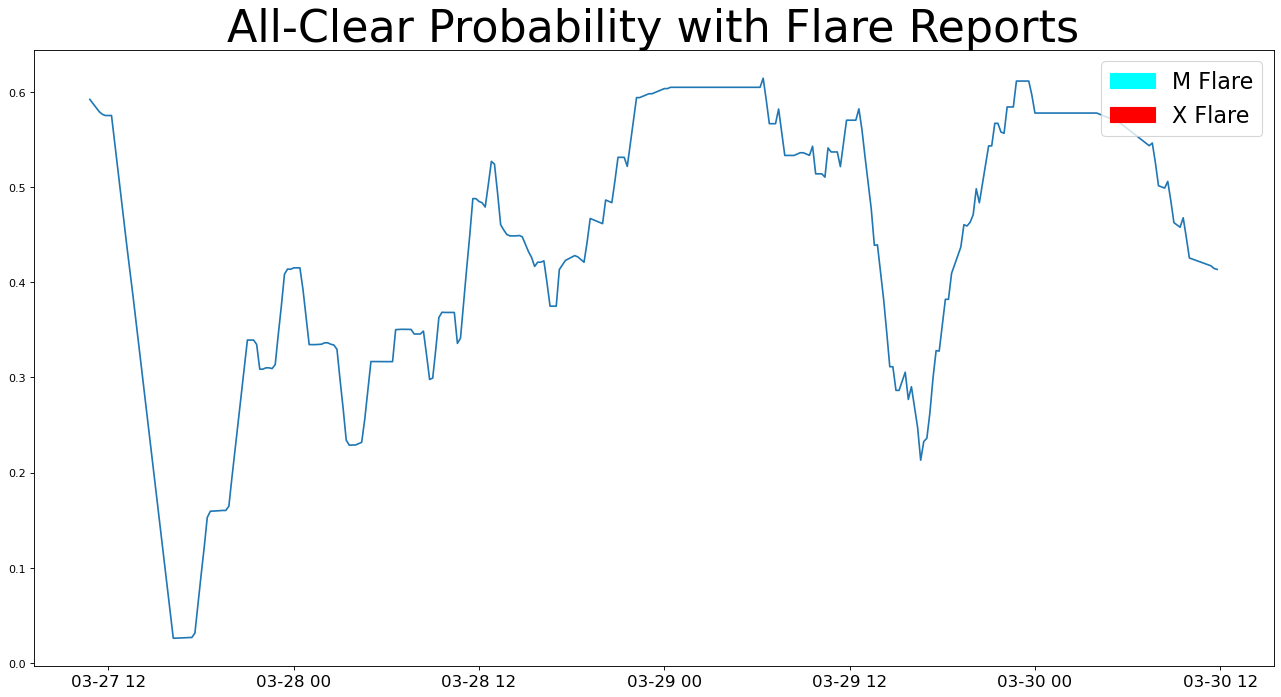

In [13]:
lineWidth = 1.5
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
#ax1.set_ylabel(pred_dataframe[1])
line1 = ax1.plot(pred_dataframe[1], pred_dataframe[0], lw=lineWidth, label="All-Clear", linestyle='solid')

m_color = 'cyan'
#m_color = 'magenta'
x_color = 'red'


for i in range(0, len(flare_dataframe[0])):
    date = flare_dataframe[0][i]
    if date is None:
        continue
    locInList = bisect(pred_dataframe[1], date, hi=len(pred_dataframe[1])-1)

    if(flare_dataframe[1][i].startswith('M')):
        plt.axvline(x=pred_dataframe[1][locInList], color=m_color, linewidth=lineWidth)
        
    if(flare_dataframe[1][i].startswith('X')):
        plt.axvline(x=pred_dataframe[1][locInList], color=x_color, linewidth=lineWidth)
    
m_patch = mpatches.Patch(color=m_color, label='M Flare')
x_patch = mpatches.Patch(color=x_color, label='X Flare')

ax1.legend(handles=[m_patch, x_patch], loc=1, fontsize=20)
plt.title("All-Clear Probability with Flare Reports", fontsize=40)
plt.xticks(fontsize=15)
plt.savefig('all-clear-and-flares.png')